In [1]:
import numpy as np
import os
import joblib
import math
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
#Definindo função para binarizar os labels
def binarize_array(numpy_array, threshold=200):
    """Binarize a numpy array."""
    for i in range(len(numpy_array)):
        for j in range(len(numpy_array[0])):
            if numpy_array[i][j] > threshold:
                numpy_array[i][j] = 255
            else:
                numpy_array[i][j] = 0
    return numpy_array

### Create numpy arrays from raw images

In [11]:
datasets = ['dataset/inca']

img_size = (128, 128)
Xall, Yall = np.array([]), np.array([])
number_of_images_total = 0

for dataset in datasets:
    print("Reading data for {}".format(dataset))
    total_images_for_dataset = 0
    dataset_folder = os.path.join('.', dataset)
    dataset_files = sorted(os.listdir(dataset_folder))
    dataset_size = len(dataset_files)
    for i in range(0, dataset_size, 2):
        number_of_images_total += 1
        total_images_for_dataset += 1
        full_image = dataset_files[i]
        segmented_image = dataset_files[i+1]
        filename = os.path.splitext(full_image)[0]
        
        # create np array image of full image
        tiff_file_path = os.path.join(dataset_folder, full_image)
        tiff_image = Image.open(tiff_file_path, 'r').convert('L').resize(img_size)
        full_image = np.array(tiff_image)
        Xall = np.append(Xall, full_image)

        # create np array image of segmented image
        tiff_file_path = os.path.join(dataset_folder, segmented_image)
        tiff_image = Image.open(tiff_file_path, 'r').convert('L').resize(img_size)
        segmented_image = np.array(tiff_image)
        segmented_image = binarize_array(segmented_image,150)
        Yall = np.append(Yall, segmented_image)
        
        if number_of_images_total % 500 == 0:
            print("{} / {} processed!".format(total_images_for_dataset, dataset_size // 2))
    print("Dataset {} finished!".format(dataset))

Xall = Xall.reshape(number_of_images_total, *img_size, 1)
Yall = Yall.reshape(number_of_images_total, *img_size, 1)


print("Generated dataset shapes. input: {} ; output: {}".format(Xall.shape, Yall.shape))

joblib.dump((Xall, Yall), 'dataset/dataset-1/all.pkl')



Reading data for dataset/inca
500 / 2054 processed!
1000 / 2054 processed!
1500 / 2054 processed!
2000 / 2054 processed!
Dataset dataset/inca finished!
Generated dataset shapes. input: (2054, 128, 128, 1) ; output: (2054, 128, 128, 1)


['dataset/dataset-1/all.pkl']

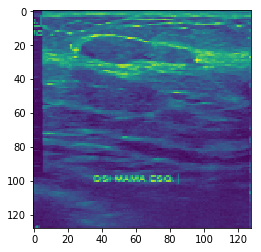

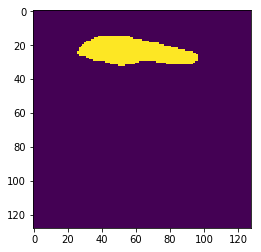

In [12]:
#Conferir alguma imagem
import matplotlib.pyplot as plt
indice = 2050
plt.imshow(Xall[indice].reshape((128,128)))
plt.show()
plt.imshow(Yall[indice].reshape((128,128)))
plt.show()

### Separate train, val and test data and save them on disk

In [13]:
Xall, Yall = joblib.load('dataset/dataset-1/all.pkl')
print(Xall.shape)
print(Yall.shape)

training_percentage = 0.7
validation_percentage = 0.1

training_set_index = math.floor(Xall.shape[0]*training_percentage)
validation_set_index = math.floor(Xall.shape[0]*validation_percentage) + training_set_index

# shuffling before training-validation-test slicing
ids = np.arange(Xall.shape[0])
np.random.shuffle(ids) # shuffle images to avoid bias in training
Xall, Yall = Xall[ids], Yall[ids]

print(Xall.shape)
print(Yall.shape)

Xte, yte = Xall[validation_set_index:,:], Yall[validation_set_index:] # X and y for testing
# test set is saved on disk. It should NOT be modified. All model evaluations MUST target the same test set.
joblib.dump((Xte, yte, {'test_percentage': 1 - training_percentage - validation_percentage }), 'dataset/dataset-1/test.pkl')

X_remaining, y_remaining = Xall[:validation_set_index,:], Yall[:validation_set_index] # X and y for training and validation
# test and val set are saved on disk. It can be loaded after and be shuffled, cross validated, etc.
config = {
            'train_percentage': training_percentage,
            'training_set_index': training_set_index,
            'val_percentage': validation_percentage,
            'validation_set_index': validation_set_index
         }
joblib.dump((X_remaining, y_remaining, config), 'dataset/dataset-1/train-and-val.pkl')

(2054, 128, 128, 1)
(2054, 128, 128, 1)
(2054, 128, 128, 1)
(2054, 128, 128, 1)


['dataset/dataset-1/train-and-val.pkl']

In [14]:
###LOAD DATASETS
train_and_val_dataset_file = 'dataset/dataset-1/train-and-val.pkl'
test_dataset_file = 'dataset/dataset-1/test.pkl'
augmented_train_dataset_save_file = 'dataset/dataset-1/train-augmented-{}.pkl'
X_remaining, Y_remaining, remaining_dataset_desc = joblib.load(train_and_val_dataset_file)
Xte, yte, test_dataset_desc = joblib.load(test_dataset_file) # X and y for test
training_set_index = remaining_dataset_desc['training_set_index']
validation_set_index = remaining_dataset_desc['validation_set_index']

Xtr, ytr = X_remaining[:training_set_index,:], Y_remaining[:training_set_index] # X and y for training
Xva, yva = X_remaining[training_set_index:validation_set_index,:], Y_remaining[training_set_index:validation_set_index] # X and y for validation

print(Xtr.shape)
print(Xva.shape)
print(Xte.shape)
print(ytr.shape)
print(yva.shape)
print(yte.shape)

(1437, 128, 128, 1)
(205, 128, 128, 1)
(412, 128, 128, 1)
(1437, 128, 128, 1)
(205, 128, 128, 1)
(412, 128, 128, 1)


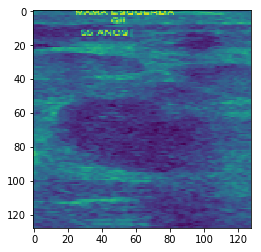

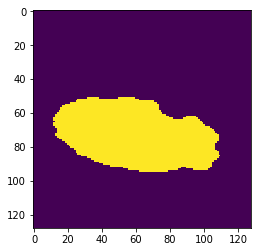

In [19]:
#Conferir alguma imagem
import matplotlib.pyplot as plt
indice = 31
plt.imshow(Xtr[indice].reshape((128,128)))
plt.show()
plt.imshow(ytr[indice].reshape((128,128)))
plt.show()

In [20]:
##DATA AUGMENTATION
txtyrange = range(-1, 1, 1) # translation range for x and y directions
loat = [ (tx, ty) for tx in txtyrange for ty in txtyrange ] # list of accepted translations
loaa = list(range(-1, 1, 1))
foia = len(loat) * len(loaa) # factor of image augmentation
print(foia)

total_imgs = Xtr.shape[0]
increment = 0

print(total_imgs*foia)

for i in range(total_imgs):
    x = Xtr[i]
    y = ytr[i]
    for (tx, ty) in loat:
        input_array = x.reshape(x.shape[0], x.shape[1])
        output_array = y.reshape(y.shape[0], y.shape[1])
        
        input_image = Image.fromarray(input_array)
        input_image = input_image.transform(input_image.size, Image.AFFINE, (1, 0, tx, 0, 1, ty)) # translated full image

        output_image = Image.fromarray(output_array)
        output_image = output_image.transform(output_image.size, Image.AFFINE, (1, 0, tx, 0, 1, ty)) # translated full image

        for a in loaa:
            increment += 1
            
            if increment % 1000 == 0:
                print("Processed {}/{}".format(increment, total_imgs*foia))
            
            input_image = input_image.rotate(a, resample=Image.BICUBIC) # rotated trcimg
            input_array_augmented = np.array(input_image) # array with pixel values
            Xtr = np.append(Xtr, input_array_augmented).reshape(total_imgs+increment, x.shape[0], x.shape[1], x.shape[2])
            
            output_image = output_image.rotate(a, resample=Image.BICUBIC) # rotated trcimg
            output_array_augmented = np.array(output_image) # array with pixel values
            ytr = np.append(ytr, output_array_augmented).reshape(total_imgs+increment, y.shape[0], y.shape[1], y.shape[2])

joblib.dump((Xtr, ytr), augmented_train_dataset_save_file.format(total_imgs*foia))

8
11496
Processed 1000/11496
Processed 2000/11496
Processed 3000/11496
Processed 4000/11496
Processed 5000/11496
Processed 6000/11496
Processed 7000/11496
Processed 8000/11496
Processed 9000/11496
Processed 10000/11496
Processed 11000/11496


['dataset/dataset-1/train-augmented-11496.pkl']

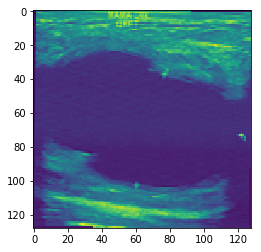

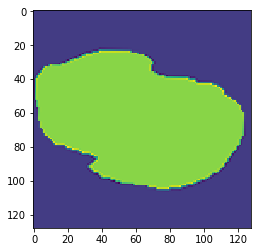

In [21]:
Xtr, ytr = joblib.load('dataset/dataset-1/train-augmented-11496.pkl')
#Conferir alguma imagem
import matplotlib.pyplot as plt
indice = 9743
plt.imshow(Xtr[indice].reshape((128,128)))
plt.show()
plt.imshow(ytr[indice].reshape((128,128)))
plt.show()